In [3]:
import os
import re
from Bio import SeqIO
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict

In [4]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

def calc_busco(buscofile, value):
    buscopat = '\s+C:([\d\.]+)%\[S:([\d\.]+)%,D:([\d\.]+)%\],F:([\d\.]+)%,M:([\d\.]+)%,n:(\d+)'
    with open(buscofile) as infile:
        for line in infile:
            hit = re.search(buscopat, line)
            if hit:
                vals = [float(i) for i in hit.groups()]
                busco = dict(zip(('complete', 
                                  'singleton', 
                                  'duplicate', 
                                  'failed', 
                                  'missing', 
                                  'n'), 
                                 vals))
                break
    return busco[value]
                

In [5]:
with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}

n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])

In [6]:
buscos = []
for species in genomes.keys():
    for file in os.listdir(f'../data/busco-out/{species}'):
        buscofile = f'../data/busco-out/{species}/{file}'
        buscos.append((species, 
                       calc_busco(buscofile, 'complete')))
busco_df = pd.DataFrame(buscos, columns=['species', 'busco_complete'])

In [7]:
qc_df = pd.merge(n50_df, busco_df, on='species')
print(qc_df.sort_values('busco_complete').reset_index())

    index                       species       N50  busco_complete
0      13                  Labeo_gonius      3580            26.0
1      10         Cirrhinus_molitorella      4199            34.8
2      14    Poropuntius_huangchuchieni      2931            36.9
3       1           Pimephales_promelas     60365            71.8
4      30                 Danio_choprai   5574156            72.7
5      23            Leuciscus_waleckii  21776898            74.0
6      24       Paedocypris_carbunculus     59221            77.7
7      28            Danio_albolineatus   4543946            78.4
8      25     Paedocypris_micromegethes     61829            79.9
9      33                 Danio_tinwini  13167244            81.1
10      2               Cyprinus_carpio   7653411            82.0
11     15    Hypophthalmichthys_nobilis     83001            83.6
12     29           Danio_jaintianensis  17381796            86.6
13     16   Hypophthalmichthys_molitrix    314070            86.9
14     26 

['Chanos_chanos', 'Pimephales_promelas', 'Cyprinus_carpio', 'Ctenopharyngodon_idella', 'Sinocyclocheilus_anshuiensis', 'Sinocyclocheilus_rhinocerous', 'Sinocyclocheilus_grahami', 'Carassius_auratus', 'Oxygymnocypris_stewartii', 'Anabarilius_grahami', 'Labeo_rohita', 'Labeo_catla', 'Hypophthalmichthys_nobilis', 'Hypophthalmichthys_molitrix', 'Triplophysa_siluroides', 'Triplophysa_tibetana', 'Triplophysa_dalaica', 'Culter_alburnus', 'Megalobrama_amblycephala', 'Onychostoma_macrolepis', 'Leuciscus_waleckii', 'Paedocypris_carbunculus', 'Paedocypris_micromegethes', 'Danionella_dracula', 'Danionella_translucida', 'Danio_albolineatus', 'Danio_jaintianensis', 'Danio_choprai', 'Danio_aesculapii', 'Danio_kyathit', 'Danio_tinwini', 'Danio_rerio']


[]

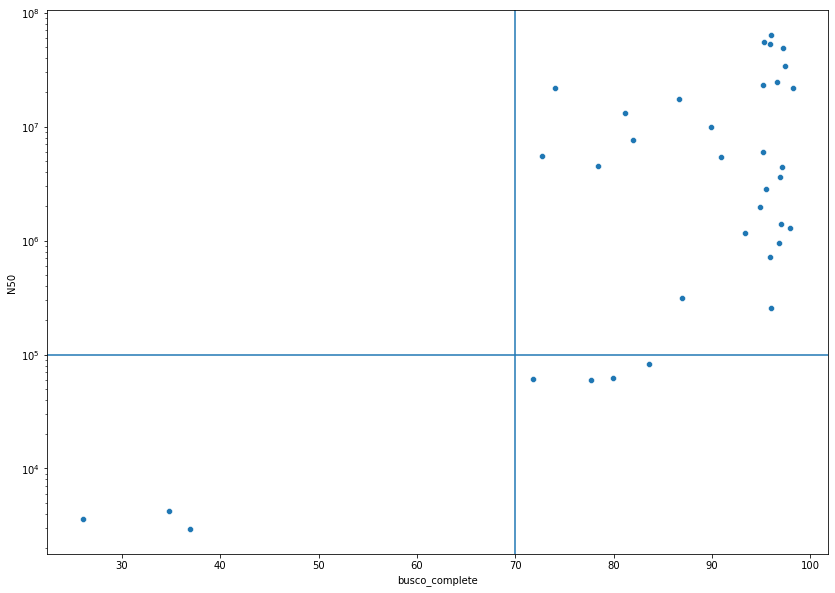

In [11]:
with open('../data/hiqual_species.txt', 'w') as outfile:
    spec = list(qc_df.loc[(qc_df.N50 > 1e05) | (qc_df.busco_complete > 70), 'species'])
    print(spec)
    outfile.write('\n'.join(spec))
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=qc_df, x='busco_complete', y='N50')
ax.set_yscale('log')
ax.axvline(x=70)
ax.axhline(y=1e05)
plt.plot()

In [80]:
coverage_df = pd.DataFrame(columns=['gene', 'position', 'depth', 'busco', 'species'])
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    df = pd.read_csv(f'../data/danio-reads/{species}_depth75.out', 
                     sep='\t', 
                     header=None, 
                     names=['gene', 'position', 'depth'])
    df['busco'] = False
    df.loc[df.gene.str.contains('\d+at\d+'), 'busco'] = True
    df['species'] = species
    coverage_df = pd.concat([coverage_df, df])
coverage_df['depth'] = coverage_df.depth.apply(pd.to_numeric)
genecov_df = coverage_df.groupby(['species', 'gene', 'busco']).median().reset_index()
print(genecov_df.head())

              species                             gene  busco  depth
0  Danio_albolineatus  Danio_albolineatus_100028at7898   True   16.0
1  Danio_albolineatus  Danio_albolineatus_100034at7898   True   14.0
2  Danio_albolineatus  Danio_albolineatus_100316at7898   True   16.0
3  Danio_albolineatus  Danio_albolineatus_100418at7898   True   13.0
4  Danio_albolineatus  Danio_albolineatus_100571at7898   True   15.0


In [81]:
genecov_df['norm'] = 0
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    genecov_df.loc[genecov_df.species == species, 'norm'] = genecov_df.loc[genecov_df.species == species, 'depth'] - genecov_df.loc[genecov_df.species == species, 'depth'].mean()
 


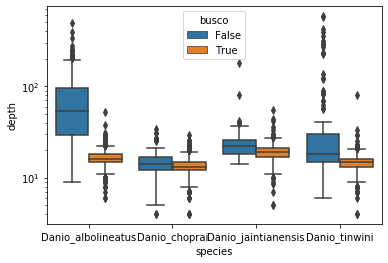

                            depth                                            \
                            count       mean         std   min   25%    50%   
species             busco                                                     
Danio_albolineatus  False   340.0  71.289706   61.758658   9.0  29.0  53.50   
                    True   1857.0  16.443188    3.084545   6.0  15.0  16.00   
Danio_choprai       False    70.0  15.142857    5.893464   4.0  12.0  14.00   
                    True   1858.0  13.531755    2.653386   4.0  12.0  13.25   
Danio_jaintianensis False    93.0  24.978495   18.257803  14.0  18.0  22.00   
                    True   1858.0  18.732777    3.375094   5.0  17.0  19.00   
Danio_tinwini       False   118.0  60.250000  109.654737   6.0  15.0  18.00   
                    True   1858.0  14.689989    3.174340   4.0  13.0  15.00   

                                          norm                         \
                            75%    max   count       mean

In [82]:
fig, ax = plt.subplots()
sns.boxplot(data=genecov_df, x='species', y='depth', hue='busco')
ax.set_yscale('log')
plt.show()
print(genecov_df.groupby(['species', 'busco']).describe())

In [183]:
gff_files = {'newannot': '../data/gffs/Danio_rerio_augustus_finz_only.gff',
             'ensembl': '../data/gffs/ensembl_finz_znf.gff',
             'refseq': '../data/gffs/refseq_finz_znf.gff'}

gffs = {}

for source, filename in gff_files.items():
    gffs[source] = defaultdict(int)
    if source == 'newannot':
        id_pattern = re.compile('ID=(\w+)')
    elif source == 'ensembl':
        id_pattern = re.compile('gene_id=(.+)?;')
    elif source == 'refseq':
        id_pattern = re.compile('gene=(.+)?;')
    
    with open(filename) as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] == 'gene':
                gid = re.search(id_pattern, line[-1]).group(1)
            elif line[2] == 'CDS':
                gffs[source][gid] += 1


exon_df = pd.DataFrame(columns=['gene', 'exons', 'source'], dtype=int)
for source, exons in gffs.items():
    exon_df = pd.concat([exon_df, pd.DataFrame([(key, val, source) for key, val in exons.items()], columns=['gene', 'exons', 'source'])])
print(exon_df.head())

  gene  exons    source
0   g9      2  newannot
1  g10      2  newannot
2  g12      3  newannot
3  g13      4  newannot
4  g19      2  newannot


In [1]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.histplot(data=exon_df, x='exons', hue='source', multiple='dodge', discrete=True, shrink=0.9)
# sns.kdeplot(data=exon_df, x='exons', hue='source', bw=0.1)
ax.set_xticks([i for i in range(1, 20)])
ax.set_xlim(0.5, 20)
ax.set_xlabel('Number of coding exons')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()

NameError: name 'plt' is not defined